# Walk Forward: A Realistic Approach to Backtesting

![](<src/10_Table_Validation Methods.png>)

In [1]:
from modules import utils
utils.configure_plotly_template(showlegend=True)

## Load the data

In [2]:
import pandas as pd
df = pd.read_parquet('../../../data/EIA/electricity_demand_ciso_preprocessed.parquet')
df

subba,PGAE,SCE,SDGE,VEA
period,,,,
2018-12-31 16:00:00-08:00,10440.0,10287.0,2414.0,75.0
2018-12-31 17:00:00-08:00,11256.0,11039.0,2566.0,86.0
...,...,...,...,...
2025-05-10 23:00:00-07:00,12846.0,14642.0,2857.0,72.0
2025-05-11 00:00:00-07:00,12053.0,13502.0,2613.0,65.0


In [3]:
df = df.resample('D').sum().interpolate(method="linear")  # or df.dropna()

In [4]:
df = df[['SDGE']]
df.columns = ['values']

In [5]:
import pandas as pd
import numpy as np

df = pd.DataFrame({"ds": df.index, "y": df["values"]})
df = df.set_index("ds")


In [6]:
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# STL decomposition
stl = STL(df["y"], period=7)
res = stl.fit()
trend = res.trend
seasonal = res.seasonal

trend.plot()

In [7]:
df["values_diff"] = df["y"].diff()
df["values_diff"].plot()
# acf and pacf side by side

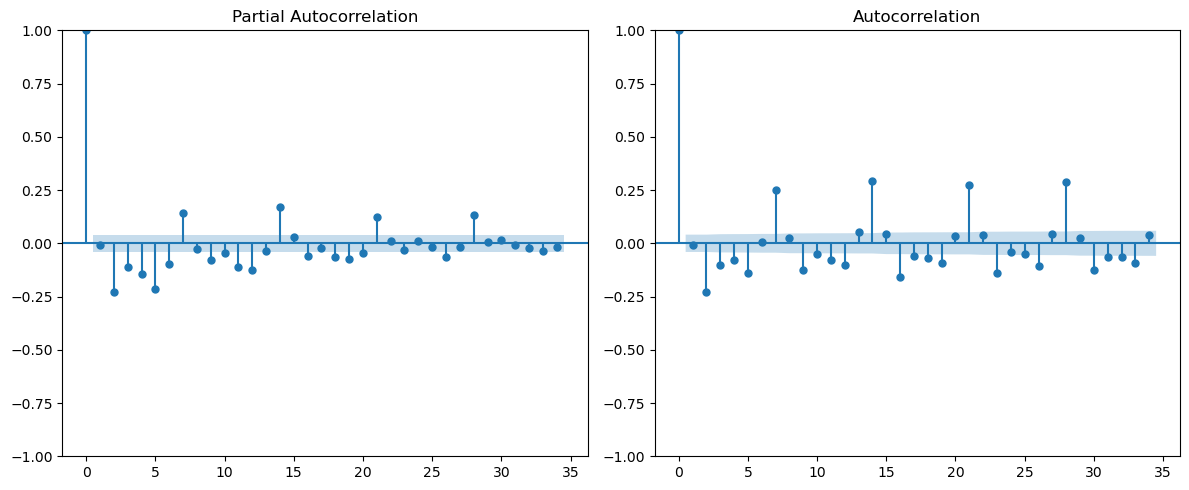

In [8]:
# acf and pacf side by side
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot_pacf(df["values_diff"].dropna(), ax=axes[0])
plot_acf(df["values_diff"].dropna(), ax=axes[1])
plt.tight_layout()
plt.show()

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Model the trend with SARIMA
model = SARIMAX(trend.dropna(), order=(1, 0, 1), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Forecast trend
n_steps = 30
forecast_trend = model_fit.forecast(steps=n_steps)
forecast_trend

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



2025-05-12 00:00:00-07:00    35404.390235
2025-05-13 00:00:00-07:00    35397.972882
                                 ...     
2025-06-09 00:00:00-07:00    35225.143363
2025-06-10 00:00:00-07:00    35218.758500
Freq: D, Name: predicted_mean, Length: 30, dtype: float64

In [12]:
trend

ds
2018-12-31 00:00:00-08:00    45008.249499
2019-01-01 00:00:00-08:00    46272.645314
                                 ...     
2025-05-10 00:00:00-07:00    38380.037141
2025-05-11 00:00:00-07:00    36503.492518
Name: trend, Length: 2324, dtype: float64

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



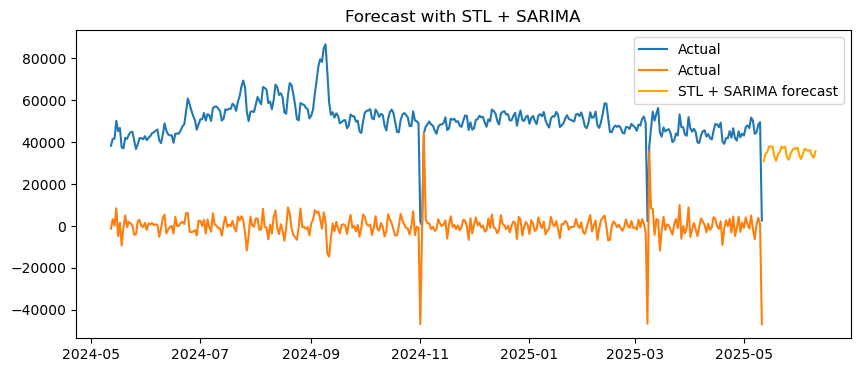

In [10]:


# Use last known seasonal pattern
forecast_seasonal = seasonal[-365:].iloc[:n_steps].values

# Final STL + SARIMA forecast
forecast_stl = forecast_trend.values + forecast_seasonal

# Plot
plt.figure(figsize=(10, 4))
plt.plot(df[-365:], label="Actual")
plt.plot(
    forecast_trend.index, forecast_stl, label="STL + SARIMA forecast", color="orange"
)
plt.legend()
plt.title("Forecast with STL + SARIMA")
plt.show()

In [ ]:
series.apply(np.log).plot()

In [10]:
df = df.tz_localize(None)

21:05:55 - cmdstanpy - INFO - Chain [1] start processing
21:05:55 - cmdstanpy - INFO - Chain [1] done processing


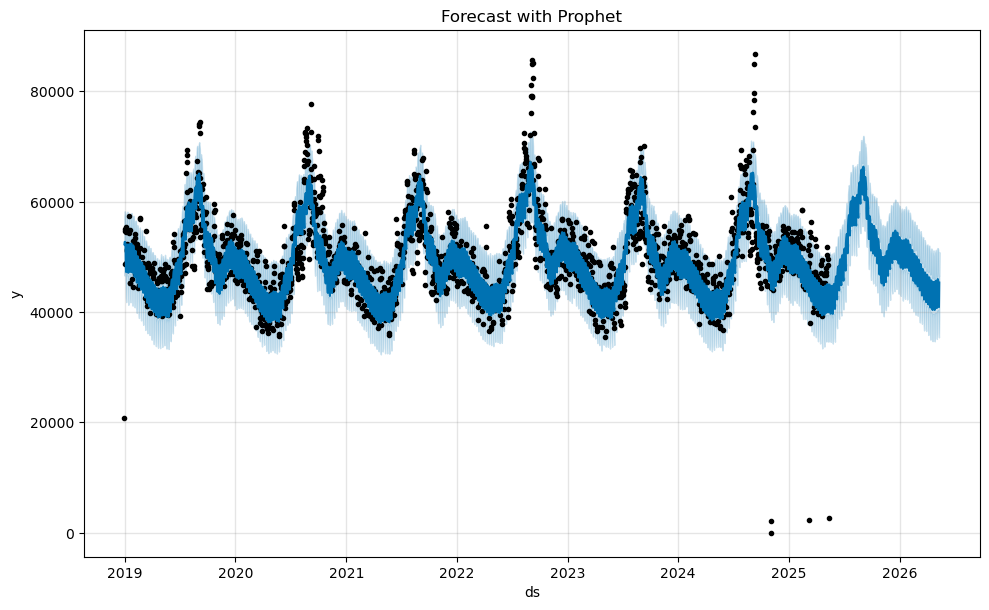

In [15]:
from prophet import Prophet

# Prophet needs columns named 'ds' and 'y'
df_prophet = df.reset_index()
model = Prophet(daily_seasonality=True)
model.fit(df_prophet)

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title("Forecast with Prophet")
plt.show()


In [16]:
forecast.head().style

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-12-31 00:00:00,26728.947509,46629.594075,57469.401393,26728.947509,26728.947509,25539.268968,25539.268968,25539.268968,23829.913643,23829.913643,23829.913643,929.525412,929.525412,929.525412,779.829914,779.829914,779.829914,0.000000,0.000000,0.000000,52268.216477
1,2019-01-01 00:00:00,26725.454270,47427.957251,58260.797656,26725.454270,26725.454270,25980.640424,25980.640424,25980.640424,23829.913643,23829.913643,23829.913643,1484.513911,1484.513911,1484.513911,666.212870,666.212870,666.212870,0.000000,0.000000,0.000000,52706.094694
2,2019-01-02 00:00:00,26721.961031,46947.615022,58197.582356,26721.961031,26721.961031,26004.437257,26004.437257,26004.437257,23829.913643,23829.913643,23829.913643,1615.065833,1615.065833,1615.065833,559.457781,559.457781,559.457781,0.000000,0.000000,0.000000,52726.398288
3,2019-01-03 00:00:00,26718.467792,47129.275858,57834.276454,26718.467792,26718.467792,25743.128028,25743.128028,25743.128028,23829.913643,23829.913643,23829.913643,1451.950916,1451.950916,1451.950916,461.263470,461.263470,461.263470,0.000000,0.000000,0.000000,52461.595821
4,2019-01-04 00:00:00,26714.974553,46338.691187,57141.128904,26714.974553,26714.974553,24985.914337,24985.914337,24985.914337,23829.913643,23829.913643,23829.913643,782.914008,782.914008,782.914008,373.086686,373.086686,373.086686,0.000000,0.000000,0.000000,51700.888890


In [24]:
forecast.set_index('ds')['yhat'].plot()

In [22]:
forecast['yhat'].plot()

In [19]:
df['values'] = np.log(df['values'])

In [20]:
df = df.resample('D').sum().div(1_000)
df.plot()

In [21]:
df = df.loc['2019':'2023']
df

,values,values_diff
period,,
2019-01-01 00:00:00-08:00,0.003887,0.000000
2019-01-02 00:00:00-08:00,0.004001,0.005909
...,...,...
2023-12-30 00:00:00-08:00,0.003886,-0.000627
2023-12-31 00:00:00-08:00,0.003892,0.000284


In [22]:
series = df['values']

In [23]:
import numpy as np

In [24]:
series.apply(np.log).plot()

In [25]:
from statsmodels.tsa.stattools import adfuller
adfuller(series)

(np.float64(-3.49563255830896),
 np.float64(0.008099970219913264),
 21,
 1804,
 {'1%': np.float64(-3.4339800605797155),
  '5%': np.float64(-2.8631434696839992),
  '10%': np.float64(-2.5676236347535166)},
 np.float64(-30146.793199371517))

In [26]:
df['values_diff'] = series.diff()

In [27]:
adfuller(df['values_diff'].dropna())

(np.float64(-10.862494990825102),
 np.float64(1.4345883894968542e-19),
 25,
 1799,
 {'1%': np.float64(-3.433990164137254),
  '5%': np.float64(-2.8631479299063405),
  '10%': np.float64(-2.567626009684832)},
 np.float64(-30123.7704391836))

In [28]:
df['values'].plot()

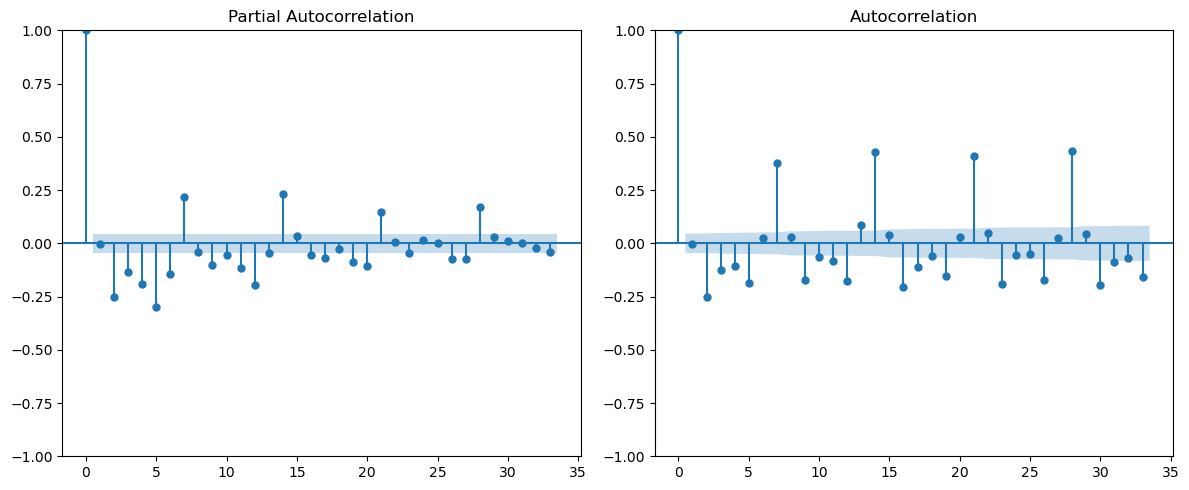

In [29]:
# acf and pacf side by side
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plot_pacf(df['values_diff'].dropna(), ax=axes[0])
plot_acf(df['values_diff'].dropna(), ax=axes[1])
plt.tight_layout()
plt.show()

In [30]:
from pmdarima import auto_arima

# Fit the auto_arima model
model = auto_arima(df['values'], seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)
results = model.fit(df['values'])
results.summary()

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=-28917.346, Time=4.32 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=-27253.834, Time=0.05 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=1.06 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=-29055.572, Time=0.64 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=-15072.865, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=-28466.004, Time=0.13 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=-29030.358, Time=1.12 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=-29253.728, Time=1.29 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=-29327.292, Time=3.18 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(2,0,2)[7] intercept   : AIC=-29385.089, Time=2.49 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,1)(2,0,1)[7] intercept   : AIC=-26150.527, Time=1.27 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=-28418.942, Time=2.25 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(2,0,2)[7] intercept   : AIC=-29170.529, Time=4.36 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,2)(2,0,2)[7] intercept   : AIC=-29914.438, Time=4.54 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,2)(1,0,2)[7] intercept   : AIC=-29930.735, Time=4.09 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,2)(0,0,2)[7] intercept   : AIC=-29585.274, Time=1.68 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,2)(1,0,1)[7] intercept   : AIC=-30010.262, Time=2.47 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,2)(0,0,1)[7] intercept   : AIC=-29444.488, Time=0.84 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,2)(1,0,0)[7] intercept   : AIC=-29422.100, Time=1.16 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,2)(2,0,1)[7] intercept   : AIC=-29908.237, Time=2.67 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,2)(0,0,0)[7] intercept   : AIC=-28945.035, Time=0.38 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,2)(2,0,0)[7] intercept   : AIC=-29862.970, Time=2.45 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=-29891.949, Time=1.83 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,3)(1,0,1)[7] intercept   : AIC=-30003.903, Time=2.06 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=-30399.203, Time=2.13 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=-29965.572, Time=0.74 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=-29413.638, Time=1.12 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=-30200.837, Time=2.88 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(1,0,2)[7] intercept   : AIC=-30216.698, Time=4.19 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=-29892.879, Time=0.32 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(0,0,2)[7] intercept   : AIC=-29940.443, Time=1.54 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=-30067.654, Time=3.84 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=-28791.426, Time=1.15 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,1)(1,0,1)[7] intercept   : AIC=-28302.294, Time=2.29 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=-28388.969, Time=1.25 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(2,0,0)(1,0,1)[7] intercept   : AIC=-29787.925, Time=1.62 sec


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,0,1)(1,0,1)[7]             : AIC=-30146.497, Time=0.21 sec

Best model:  ARIMA(1,0,1)(1,0,1)[7] intercept
Total fit time: 69.657 seconds


/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1826
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               15205.602
Date:                           Mon, 12 May 2025   AIC                         -30399.203
Time:                                   20:50:41   BIC                         -30366.144
Sample:                               01-01-2019   HQIC                        -30387.009
                                    - 12-31-2023                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.271e-08   6.83e-08     -0.479      0.632   -1.67e-07    1.01e-07
ar.L1          0.8657   2.66e-08   3.25e+07      0.000       0.866       0.866
ma.L1          0.0683   2.94e-08   2.32e+06      0.000       0.068       0.068
ar.S.L7        0.9998      0.000   5243.185      0.000       0.999       1.000
ma.S.L7       -0.5890   2.49e-07  -2.37e+06      0.000      -0.589      -0.589
sigma2      3.077e-09   9.22e-11     33.374      0.000     2.9e-09    3.26e-09
===================================================================================
Ljung-Box (L1) (Q):                  15.33   Jarque-Bera (JB):               107.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.07
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.91e+23. Standard errors may be unstable.
"""

In [31]:
forecast = results.predict(n_periods=7*8).rename('forecast')

/Users/sota/miniforge3/envs/time-series/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [33]:
forecast

2024-01-01 00:00:00-08:00    0.003946
2024-01-02 00:00:00-08:00    0.003961
                               ...   
2024-02-24 00:00:00-08:00    0.003883
2024-02-25 00:00:00-08:00    0.003867
Freq: D, Name: forecast, Length: 56, dtype: float64

In [34]:
df_forecast = df.copy()
df_forecast = pd.concat([df_forecast, forecast]).sort_index()
df_forecast

,values,values_diff,forecast
2019-01-01 00:00:00-08:00,0.003887,NaN,NaN
2019-01-02 00:00:00-08:00,0.004001,0.000114,NaN
...,...,...,...
2024-02-24 00:00:00-08:00,NaN,NaN,0.003883
2024-02-25 00:00:00-08:00,NaN,NaN,0.003867


In [35]:
df_forecast[['values', 'forecast']].plot()